# MLBio- HW05
## Generative Adversarial Networks


---

Name: $Hadis$ $Ahmadian$

Student No.: $400211524$

---

**!!! CAUTION !!!**

* To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.


More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)
```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}
setInterval(ClickConnect,60000)
```
---


In [1]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [2]:
!pip install gpustat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 3.8 MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-py3-none-any.whl size=12617 sha256=08866da78d75b409c4c9cf5aa6ee639c31b03c2bdb0444c907218fbb5c2711cf
  Stored in directory: /root/.cache/pip/wheels/e6/67/af/f1ad15974b8fd95f59a63dbf854483ebe5c7a46a93930798b8
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=9421771fe4573d142a08c04c7a727008ca8e77743ff5365accbea5181516de7d
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built gpustat nvidia-ml-py3


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm

%matplotlib inline

In [4]:
CUDA = True

device = torch.device("cuda:0" if CUDA else "cpu")

In [5]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1) Auxiliary Modules

In [6]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

# 2) GAN Training Structure (14 points)

Complete the following class to define the GAN training structure.

In [7]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments: \n
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch. \n
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`. \n
  `generator`: The generator. \n
  `discriminator`: The discriminator. The last layer is a LINEAR layer. \n
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    self.opt_G = torch.optim.Adam(generator.parameters(), lr=G_lr)
    self.opt_D = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = NoiseGenerator([50]).forward(n)
    fake_samples = self.generator(noise)
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    x_fake = self.generate_samples(n)[1]
    logits = self.discriminator(x_fake)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = torch.mean(-1*torch.log(logits))
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      loss = (1/n)*torch.mean(torch.log(1-logits))
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. What is the value of `n`? why?
    #  put them in `x_fake`
    # 2) Detach the generated samples. why?
    ####################################################
    x_fake =  self.generate_samples(len(x_real))[1]
    x_fake=x_fake.detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################
    loss = -1*(torch.mean(torch.log(1-self.discriminator(x_fake)))+torch.mean(torch.log(self.discriminator(x_real))))
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times, verbose=True):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)

      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 3) Zero out `opt_D`'s gradients
        # 4) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 5) Backpropagate `D_loss`
        # 6) Update ``discriminator` parameters
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 3) Zero out `opt_G`'s gradients
        # 4) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 5) Backpropagate `G_loss`
        # 6) Update `generator` parameters
        ####################################################
        nn=1
        self.generator.train()
        self.discriminator.eval()
        self.opt_G.zero_grad()
        G_loss = self.G_step(nn)[0]
        G_loss.backward()
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if verbose and batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    if verbose:
        print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self, verbose=True):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ####################################################
        nn=1
        self.generator.train()
        self.discriminator.eval()
        self.opt_G.zero_grad()
        G_loss = self.G_step(nn)[0]
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    if verbose:
      print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1, verbose=True):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    !gpustat
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times, verbose)
        self.test(verbose)
        self.visualization_helper_fn(self)
        if epoch == 1:
          !gpustat


---

# 3) Part 1 - 2D Toy Dataset

In the first part, we will learn density of toy datasets to examine GAN training.

## 3.1) Helper functions
These are functions used in visulization.

In [8]:
def toy2d_density_plot(samples, title, ax=None):
  """
  This function plots the distribution of `samples`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  sns.kdeplot(samples[:, 0], samples[:, 1], shade=True, ax=ax)
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [9]:
def toy2d_decision_boundary_plot(samples, labels, title, ax=None):
  """
  This function plots regions corresponding to each label value. Can be used to
  understand the decision boundary of `discriminator`.
  """
  fig = None
  if ax is None:
    fig, ax = plt.subplots(1, figsize=(3, 3))

  samples = samples.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()

  sns.scatterplot(
      x=samples[:, 0],
      y=samples[:, 1],
      hue=labels,
      legend='brief',
      marker='.',
      ax=ax
      )
  ax.set_title(title)

  if fig is not None:
    plt.show()

In [10]:
def toy2d_visulization_helper_fn(trainer: GANTrainer):
  """
  Used to visualize generator's distribution and 
  discriminator's decision boundary.
  """
  rows = 1
  cols = 2
  fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=(3 * cols, 3 * rows))

  _, fake_samples = trainer.generate_samples(10000)
  random_samples = (torch.rand((10000, 2)) - .5) * 3 * R
  random_samples = random_samples.to(device)
  with torch.no_grad():
    disc_labels = torch.sigmoid(trainer.discriminator(random_samples))[:, 0]
  
  toy2d_density_plot(fake_samples, 'generator distribution', axs[0][0])
  toy2d_decision_boundary_plot(random_samples, disc_labels, 'discriminator decision boundary', axs[0][1])

  plt.show()

## 3.2) Defining Toy Datasets

In [11]:
class Toy2dCircularGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes` gaussians on a circle with 'r' radius.
  """
  def __init__(self, r=10, std_dev=1, n_modes=20, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples,))
    theta = 2 * np.pi / n_modes * self.mode_ids
    mu = self.r * torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

In [12]:
class Toy2dGridGaussiansDataset(torch.utils.data.Dataset):
  """
  This dataset puts 'n_modes^2` gaussians on a grid with '2r' width and height.
  """
  def __init__(self, r=1, std_dev=1, n_modes=5, n_samples=10000):
    self.r = r
    self.std_dev = std_dev
    self.n_modes = n_modes
    assert n_modes >= 2
    
    self.mode_ids = torch.randint(high=self.n_modes, size=(n_samples, 2))
    mu = self.mode_ids * (2 * self.r / (self.n_modes - 1)) - self.r
    self.samples = torch.randn((n_samples, 2)) * self.std_dev + mu
  
  def __getitem__(self, i):  
    return self.samples[i], self.mode_ids[i]

  def __len__(self):
    return self.samples.shape[0]

## 3.3) Dataset Loading


You can load either `Toy2dCircularGaussiansDataset` or `Toy2dGridGaussiansDataset` to play with it; but the question at the end of this part is for the `Toy2dGridGaussiansDataset` dataset.

In [13]:
# parameters of toy dataset
TRAIN_SIZE = 60000
TEST_SIZE = 10000
R = 1

# ############### To use `Toy2dCircularGaussiansDataset` ############### #
# N_MODES = 8
# STD_DEV = 25e-3
# toy2d_train_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
# toy2d_test_dataset = Toy2dCircularGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

# ################# To use `Toy2dGridGaussiansDataset` ################# #
N_MODES = 4
STD_DEV = 1e-4
toy2d_train_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TRAIN_SIZE)
toy2d_test_dataset = Toy2dGridGaussiansDataset(R, STD_DEV, N_MODES, TEST_SIZE)
# ###################################################################### #

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


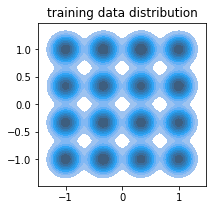

In [14]:
# Ploting dataset distribution to see it :)

toy2d_density_plot(toy2d_train_dataset[:10000][0], 'training data distribution')

## 3.4) Defining Models (4 points)

In [15]:
# Generator part
#################### Problem 12 (2 points) ####################
# 1) Define `toy2d_noise_generator`.
# 2) Define `toy2d_generator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer.
####################################################
toy2d_noise_generator = NoiseGenerator(50)

toy2d_generator = nn.Sequential(
          torch.nn.Linear(50,1000),
          torch.nn.Tanh(),
          torch.nn.Linear(1000,5000),
          torch.nn.Tanh(),
          torch.nn.Linear(5000,1000),
          torch.nn.Tanh(),
          torch.nn.Linear(1000,100),
          torch.nn.Tanh(),
          torch.nn.Linear(100,50),
          torch.nn.Tanh(),
          torch.nn.Linear(50,10),
          torch.nn.Tanh(),
          torch.nn.Linear(10,2),
          torch.nn.Tanh()

)
####################### End ########################

# Discriminator part
#################### Problem 13 (2 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `Tanh` for intermediate layers.
#    Use `Linear` for the last layer. why?
####################################################
toy2d_discriminator = nn.Sequential(
          torch.nn.Linear(2,50),
          torch.nn.Tanh(),
          torch.nn.Linear(50,200),
          torch.nn.Tanh(),
          torch.nn.Linear(200,1000),
          torch.nn.Tanh(),
          torch.nn.Linear(1000,200),
          torch.nn.Tanh(),
          torch.nn.Linear(200,50),
          torch.nn.Tanh(),
          torch.nn.Linear(50,20),
          torch.nn.Tanh(),
          torch.nn.Linear(20,5),
          torch.nn.Tanh(),
          torch.nn.Linear(5,1),
          torch.nn.Sigmoid()
)
####################### End ########################

toy2d_generator = toy2d_generator.to(device)
toy2d_discriminator = toy2d_discriminator.to(device)

print(toy2d_generator)
print(toy2d_discriminator)

Sequential(
  (0): Linear(in_features=50, out_features=1000, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1000, out_features=5000, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5000, out_features=1000, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1000, out_features=100, bias=True)
  (7): Tanh()
  (8): Linear(in_features=100, out_features=50, bias=True)
  (9): Tanh()
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): Tanh()
  (12): Linear(in_features=10, out_features=2, bias=True)
  (13): Tanh()
)
Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=1000, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1000, out_features=200, bias=True)
  (7): Tanh()
  (8): Linear(in_features=200, out_features=50, bias=True)
  (9): Tanh()
  (10): Linear(in_features=50, out_features=20, bias=True)
  (11): Tanh()
  (12): Line

## 3.5) Train

### 3.5.1) Batching Data

In [16]:
BATCH_SIZE = 1024

toy2d_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

toy2d_train_dataloader = torch.utils.data.DataLoader(toy2d_train_dataset, **toy2d_dataloader_kwargs)
toy2d_test_dataloader = torch.utils.data.DataLoader(toy2d_test_dataset, **toy2d_dataloader_kwargs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 3.5.2) Run (2 points)

In [17]:
LOG_INTERVAL = 50
#################### Problem 14 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
TOY2D_G_LEARNING_RATE = 0.01
TOY2D_D_LEARNING_RATE = 0.01
G_LOSS_MODE = 'logD'
####################### End ########################

toy2d_trainer = GANTrainer(toy2d_train_dataloader, toy2d_test_dataloader,
                           toy2d_noise_generator, toy2d_generator, toy2d_discriminator,
                           TOY2D_G_LEARNING_RATE, TOY2D_D_LEARNING_RATE,
                           toy2d_visulization_helper_fn, G_LOSS_MODE)

8f57092302b0         Tue Aug  2 02:11:43 2022  460.32.03
[0] Tesla T4         | 42'C,   2 % |   654 / 15109 MB |


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 1 [0/60416]		D-Loss: 1.380159	G-Loss: 0.719845
Train | Epoch: 1 [51200/60416]		D-Loss: 1.098260	G-Loss: 0.957056
====> Train | Epoch: 1 	 | 	Average D-loss: 1.2457 	 | 	Average G-loss: 0.8534


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
    assert self._pa

====> Test | Average D-loss: 1.0676 	 | 	Average G-loss: 0.9612


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


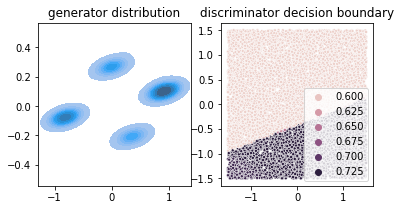

8f57092302b0         Tue Aug  2 02:11:59 2022  460.32.03
[0] Tesla T4         | 46'C,   0 % |  1526 / 15109 MB |


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 2 [0/60416]		D-Loss: 1.078898	G-Loss: 0.969339
Train | Epoch: 2 [51200/60416]		D-Loss: 1.128442	G-Loss: 0.919822
====> Train | Epoch: 2 	 | 	Average D-loss: 1.1265 	 | 	Average G-loss: 0.9043


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

====> Test | Average D-loss: 1.1118 	 | 	Average G-loss: 0.8554


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


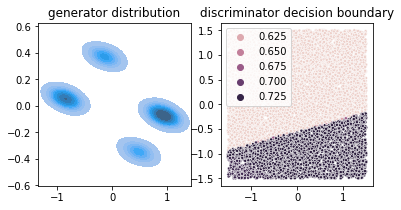

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 3 [0/60416]		D-Loss: 1.149923	G-Loss: 0.901880
Train | Epoch: 3 [51200/60416]		D-Loss: 1.148892	G-Loss: 0.878806
====> Train | Epoch: 3 	 | 	Average D-loss: 1.1347 	 | 	Average G-loss: 0.8916


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1109 	 | 	Average G-loss: 0.8480


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


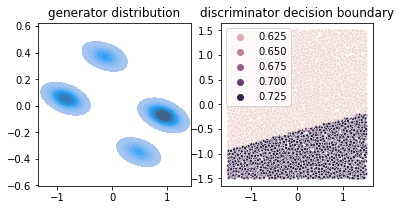

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 4 [0/60416]		D-Loss: 1.143063	G-Loss: 0.879314
Train | Epoch: 4 [51200/60416]		D-Loss: 1.120324	G-Loss: 0.929276
====> Train | Epoch: 4 	 | 	Average D-loss: 1.1340 	 | 	Average G-loss: 0.8913


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1098 	 | 	Average G-loss: 0.8849


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


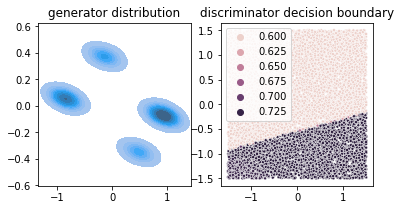

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 5 [0/60416]		D-Loss: 1.143630	G-Loss: 0.925282
Train | Epoch: 5 [51200/60416]		D-Loss: 1.152442	G-Loss: 0.886675
====> Train | Epoch: 5 	 | 	Average D-loss: 1.1337 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1102 	 | 	Average G-loss: 0.8485


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


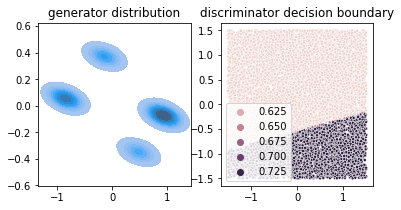

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 6 [0/60416]		D-Loss: 1.147264	G-Loss: 0.887745
Train | Epoch: 6 [51200/60416]		D-Loss: 1.145933	G-Loss: 0.910012
====> Train | Epoch: 6 	 | 	Average D-loss: 1.1335 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

====> Test | Average D-loss: 1.1095 	 | 	Average G-loss: 0.8968


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


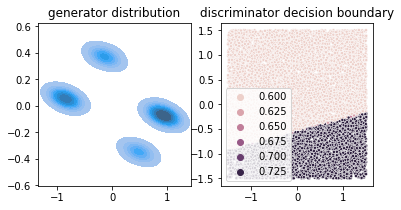

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 7 [0/60416]		D-Loss: 1.134950	G-Loss: 0.915490
Train | Epoch: 7 [51200/60416]		D-Loss: 1.137379	G-Loss: 0.902871
====> Train | Epoch: 7 	 | 	Average D-loss: 1.1334 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1093 	 | 	Average G-loss: 0.8727


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


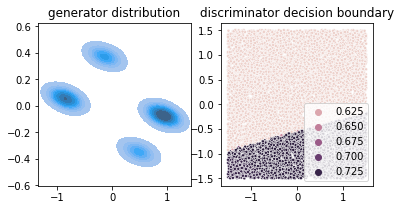

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 8 [0/60416]		D-Loss: 1.141834	G-Loss: 0.886457
Train | Epoch: 8 [51200/60416]		D-Loss: 1.164293	G-Loss: 0.865767
====> Train | Epoch: 8 	 | 	Average D-loss: 1.1333 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1106 	 | 	Average G-loss: 0.9301


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


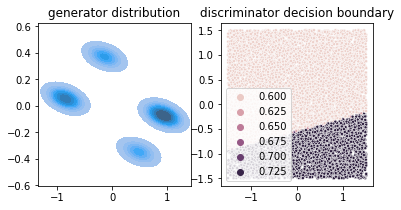

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 9 [0/60416]		D-Loss: 1.148235	G-Loss: 0.899857
Train | Epoch: 9 [51200/60416]		D-Loss: 1.140988	G-Loss: 0.877168
====> Train | Epoch: 9 	 | 	Average D-loss: 1.1333 	 | 	Average G-loss: 0.8914


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1093 	 | 	Average G-loss: 0.8710


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


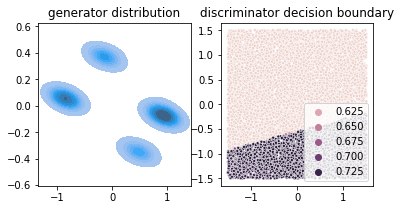

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 10 [0/60416]		D-Loss: 1.148787	G-Loss: 0.905019
Train | Epoch: 10 [51200/60416]		D-Loss: 1.144417	G-Loss: 0.909499
====> Train | Epoch: 10 	 | 	Average D-loss: 1.1332 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

====> Test | Average D-loss: 1.1109 	 | 	Average G-loss: 0.8284


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


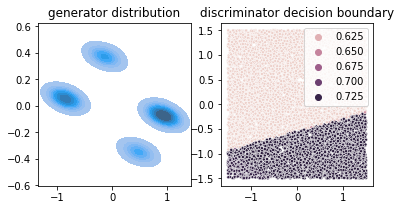

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 11 [0/60416]		D-Loss: 1.138625	G-Loss: 0.889931
Train | Epoch: 11 [51200/60416]		D-Loss: 1.150390	G-Loss: 0.885810
====> Train | Epoch: 11 	 | 	Average D-loss: 1.1333 	 | 	Average G-loss: 0.8920


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1097 	 | 	Average G-loss: 0.9122


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


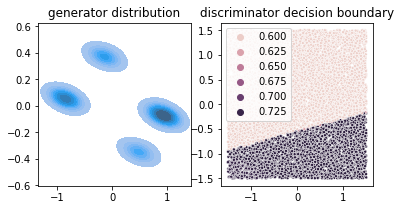

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 12 [0/60416]		D-Loss: 1.128445	G-Loss: 0.913230
Train | Epoch: 12 [51200/60416]		D-Loss: 1.122585	G-Loss: 0.897912
====> Train | Epoch: 12 	 | 	Average D-loss: 1.1332 	 | 	Average G-loss: 0.8917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

====> Test | Average D-loss: 1.1113 	 | 	Average G-loss: 0.8228


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


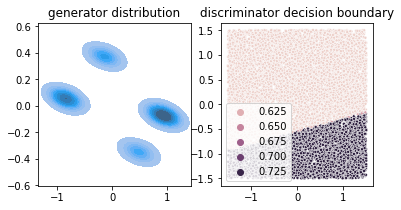

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 13 [0/60416]		D-Loss: 1.150800	G-Loss: 0.878007
Train | Epoch: 13 [51200/60416]		D-Loss: 1.131067	G-Loss: 0.915057
====> Train | Epoch: 13 	 | 	Average D-loss: 1.1332 	 | 	Average G-loss: 0.8919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1092 	 | 	Average G-loss: 0.8678


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


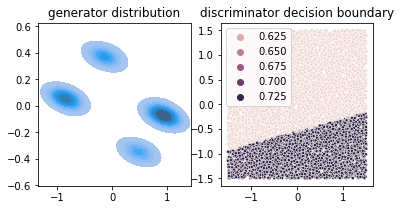

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 14 [0/60416]		D-Loss: 1.135485	G-Loss: 0.917000
Train | Epoch: 14 [51200/60416]		D-Loss: 1.163450	G-Loss: 0.899808
====> Train | Epoch: 14 	 | 	Average D-loss: 1.1331 	 | 	Average G-loss: 0.8920


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

====> Test | Average D-loss: 1.1093 	 | 	Average G-loss: 0.8993


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


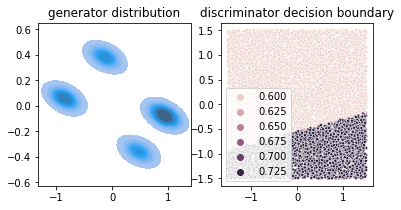

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 15 [0/60416]		D-Loss: 1.153793	G-Loss: 0.866451
Train | Epoch: 15 [51200/60416]		D-Loss: 1.129203	G-Loss: 0.915836
====> Train | Epoch: 15 	 | 	Average D-loss: 1.1331 	 | 	Average G-loss: 0.8917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1103 	 | 	Average G-loss: 0.9270


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


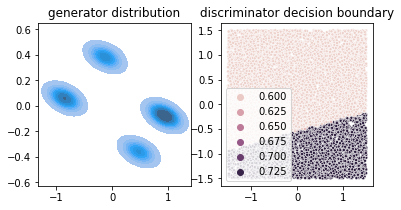

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 16 [0/60416]		D-Loss: 1.150799	G-Loss: 0.895293
Train | Epoch: 16 [51200/60416]		D-Loss: 1.127499	G-Loss: 0.907737
====> Train | Epoch: 16 	 | 	Average D-loss: 1.1332 	 | 	Average G-loss: 0.8919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1093 	 | 	Average G-loss: 0.8986


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


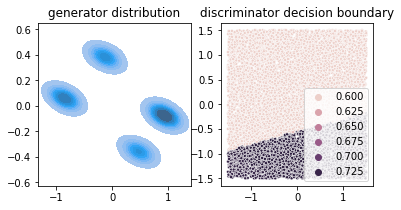

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 17 [0/60416]		D-Loss: 1.123879	G-Loss: 0.918305
Train | Epoch: 17 [51200/60416]		D-Loss: 1.131062	G-Loss: 0.896961
====> Train | Epoch: 17 	 | 	Average D-loss: 1.1331 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1095 	 | 	Average G-loss: 0.9076


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


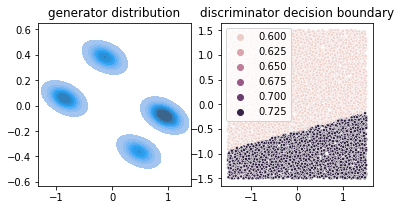

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 18 [0/60416]		D-Loss: 1.135414	G-Loss: 0.888306
Train | Epoch: 18 [51200/60416]		D-Loss: 1.112466	G-Loss: 0.959307
====> Train | Epoch: 18 	 | 	Average D-loss: 1.1331 	 | 	Average G-loss: 0.8918


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1091 	 | 	Average G-loss: 0.8742


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


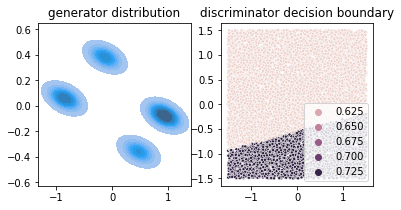

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 19 [0/60416]		D-Loss: 1.152053	G-Loss: 0.875242
Train | Epoch: 19 [51200/60416]		D-Loss: 1.141562	G-Loss: 0.895942
====> Train | Epoch: 19 	 | 	Average D-loss: 1.1331 	 | 	Average G-loss: 0.8919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1091 	 | 	Average G-loss: 0.8854


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


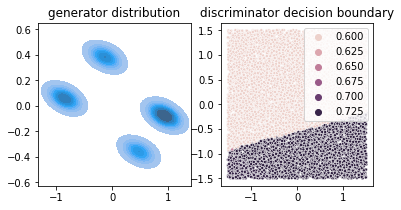

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/59 [00:00<?, ?it/s]

Train | Epoch: 20 [0/60416]		D-Loss: 1.134501	G-Loss: 0.898792
Train | Epoch: 20 [51200/60416]		D-Loss: 1.142399	G-Loss: 0.891892
====> Train | Epoch: 20 	 | 	Average D-loss: 1.1332 	 | 	Average G-loss: 0.8917


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc6601017a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

====> Test | Average D-loss: 1.1097 	 | 	Average G-loss: 0.8494


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


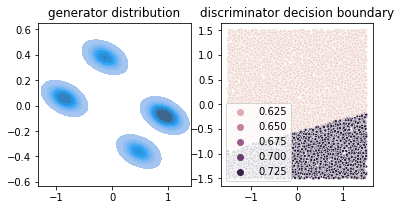

In [18]:
#################### Problem 15 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
toy2d_trainer.run(n_epoch=20, G_update_times=1, D_update_times=5, verbose=True)
####################### End ########################

### 3.5.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 12 to 15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


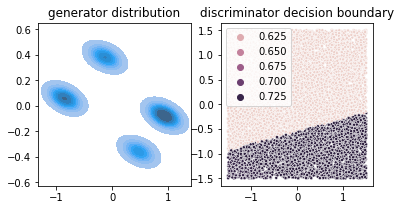

In [19]:
toy2d_visulization_helper_fn(toy2d_trainer)

# 4) Part 2 - MNIST

In the second part, we will learn to generate MNIST like samples.

## 4.1) Helper functions
These are functions used in visulization.

In [20]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result

In [21]:
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows) # set default size of plots  TODO float(folan)?
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

In [22]:
def mnist_visulization_helper_fn(trainer: GANTrainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

In [23]:
def show_interpolations(trainer:GANTrainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

## 4.2) Dataset Loading

In [24]:
# Get MNIST dataloader

mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1, # to make pixel values between [-1, 1]
                                    #  lambda img: torch.transpose(img, 1, 2)
                                     ])
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)

print(len(mnist_train_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000


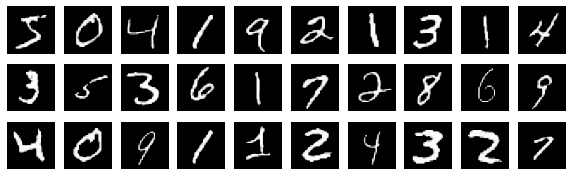

In [25]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

## 4.3) Defining Models (6 points)

idea for MNIST network desighn :https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/

In [93]:
# Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_noise_generator = NoiseGenerator(50)

mnist_generator = nn.Sequential(
            
            nn.Linear(50, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
          
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `toy2d_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer. why?
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): Linear(in_features=50, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=1024, out_features=784, bias=True)
  (7): Tanh()
)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): Dropout(p=0.3, inplace=False)
  (10): Linear(in_features=256, out_features=1, bias=True)
  (11): Sigmoid()
)


## 4.4) Train

### 4.4.1) Batching Data

you can use `train_sampler` and `test_sampler` to test your model on smaller subset of dataset; but, the final report must be on the whole dataset.

In [94]:
BATCH_SIZE = 256

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 4,
}

# ############### To use complete dataset ############### #
train_sampler = None
test_sampler = None
mnist_dataloader_kwargs['shuffle'] = True
# ####################################################### #

# ############### To use subsample of dataset ############### #
# train_sampler = torch.utils.data.RandomSampler(mnist_train_dataset, replacement=True, num_samples=10000)
# test_sampler = torch.utils.data.RandomSampler(mnist_test_dataset, replacement=True, num_samples=2000)
# mnist_dataloader_kwargs['shuffle'] = False
# ########################################################### #

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler=train_sampler, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler=test_sampler, **mnist_dataloader_kwargs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 4.4.2) Run (2 points)

In [95]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.0002
MNIST_D_LEARNING_RATE = 0.0002
G_LOSS_MODE = "logD"
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

8f57092302b0         Tue Aug  2 03:11:23 2022  460.32.03
[0] Tesla T4         | 56'C,   0 % |  1824 / 15109 MB |


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 1 [0/60160]		D-Loss: 1.358830	G-Loss: 0.693798
Train | Epoch: 1 [12800/60160]		D-Loss: 0.256950	G-Loss: 2.500737
Train | Epoch: 1 [25600/60160]		D-Loss: 0.021595	G-Loss: 6.483890
Train | Epoch: 1 [38400/60160]		D-Loss: 0.530765	G-Loss: 1.887738
Train | Epoch: 1 [51200/60160]		D-Loss: 0.676750	G-Loss: 0.892331
====> Train | Epoch: 1 	 | 	Average D-loss: 0.6805 	 | 	Average G-loss: 2.3307
====> Test | Average D-loss: 0.9979 	 | 	Average G-loss: 0.7319


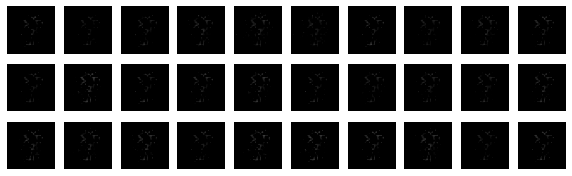

8f57092302b0         Tue Aug  2 03:11:56 2022  460.32.03
[0] Tesla T4         | 56'C,   0 % |  1824 / 15109 MB |


  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 2 [0/60160]		D-Loss: 1.066060	G-Loss: 0.421992
Train | Epoch: 2 [12800/60160]		D-Loss: 0.237807	G-Loss: 6.429317
Train | Epoch: 2 [25600/60160]		D-Loss: 1.281332	G-Loss: 1.712293
Train | Epoch: 2 [38400/60160]		D-Loss: 0.625664	G-Loss: 3.522120
Train | Epoch: 2 [51200/60160]		D-Loss: 0.624554	G-Loss: 2.960169
====> Train | Epoch: 2 	 | 	Average D-loss: 0.6502 	 | 	Average G-loss: 4.6433
====> Test | Average D-loss: 0.1700 	 | 	Average G-loss: 3.4311


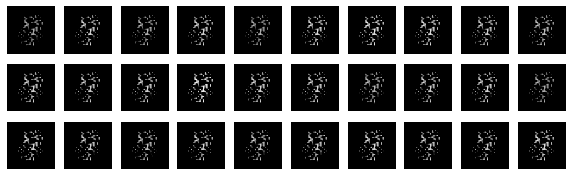

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 3 [0/60160]		D-Loss: 0.150669	G-Loss: 4.724182
Train | Epoch: 3 [12800/60160]		D-Loss: 0.114537	G-Loss: 4.470071
Train | Epoch: 3 [25600/60160]		D-Loss: 0.901154	G-Loss: 2.212278
Train | Epoch: 3 [38400/60160]		D-Loss: 0.435071	G-Loss: 2.203334
Train | Epoch: 3 [51200/60160]		D-Loss: 1.026054	G-Loss: 3.048354
====> Train | Epoch: 3 	 | 	Average D-loss: 0.7795 	 | 	Average G-loss: 2.8863
====> Test | Average D-loss: 1.0272 	 | 	Average G-loss: 1.1251


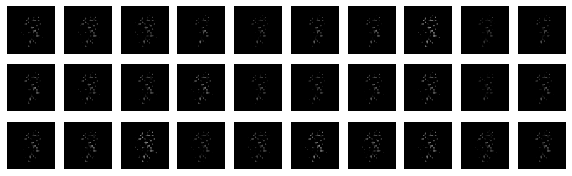

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 4 [0/60160]		D-Loss: 1.138819	G-Loss: 4.771072
Train | Epoch: 4 [12800/60160]		D-Loss: 1.021664	G-Loss: 2.329603
Train | Epoch: 4 [25600/60160]		D-Loss: 1.011238	G-Loss: 1.303393
Train | Epoch: 4 [38400/60160]		D-Loss: 0.181480	G-Loss: 2.700485
Train | Epoch: 4 [51200/60160]		D-Loss: 1.126860	G-Loss: 0.541547
====> Train | Epoch: 4 	 | 	Average D-loss: 1.0500 	 | 	Average G-loss: 1.8406
====> Test | Average D-loss: 0.9218 	 | 	Average G-loss: 1.0941


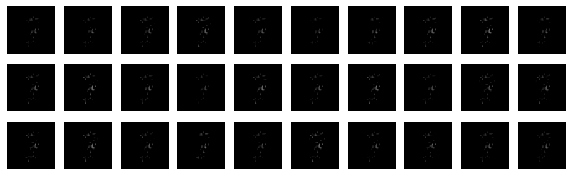

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 5 [0/60160]		D-Loss: 0.944565	G-Loss: 1.521679
Train | Epoch: 5 [12800/60160]		D-Loss: 0.750632	G-Loss: 1.144186
Train | Epoch: 5 [25600/60160]		D-Loss: 1.723938	G-Loss: 0.429715
Train | Epoch: 5 [38400/60160]		D-Loss: 0.371017	G-Loss: 2.677360
Train | Epoch: 5 [51200/60160]		D-Loss: 0.698233	G-Loss: 1.792846
====> Train | Epoch: 5 	 | 	Average D-loss: 0.8417 	 | 	Average G-loss: 1.9026
====> Test | Average D-loss: 0.9320 	 | 	Average G-loss: 2.1625


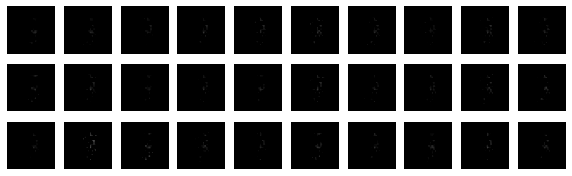

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 6 [0/60160]		D-Loss: 0.900700	G-Loss: 1.911887
Train | Epoch: 6 [12800/60160]		D-Loss: 1.609972	G-Loss: 1.830140
Train | Epoch: 6 [25600/60160]		D-Loss: 0.667551	G-Loss: 1.741102
Train | Epoch: 6 [38400/60160]		D-Loss: 0.249289	G-Loss: 4.095988
Train | Epoch: 6 [51200/60160]		D-Loss: 1.453938	G-Loss: 0.897195
====> Train | Epoch: 6 	 | 	Average D-loss: 0.7477 	 | 	Average G-loss: 3.1759
====> Test | Average D-loss: 0.1423 	 | 	Average G-loss: 6.0617


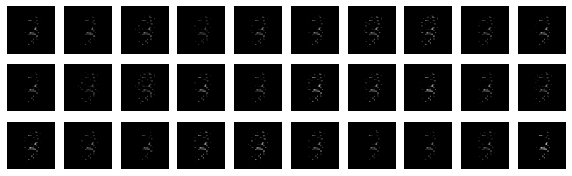

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 7 [0/60160]		D-Loss: 0.143944	G-Loss: 8.210151
Train | Epoch: 7 [12800/60160]		D-Loss: 0.190509	G-Loss: 5.273767
Train | Epoch: 7 [25600/60160]		D-Loss: 0.306891	G-Loss: 3.799400
Train | Epoch: 7 [38400/60160]		D-Loss: 0.678922	G-Loss: 5.120736
Train | Epoch: 7 [51200/60160]		D-Loss: 0.558653	G-Loss: 3.116990
====> Train | Epoch: 7 	 | 	Average D-loss: 0.6631 	 | 	Average G-loss: 3.3271
====> Test | Average D-loss: 0.3652 	 | 	Average G-loss: 2.7154


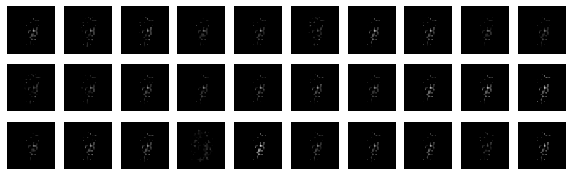

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 8 [0/60160]		D-Loss: 0.367622	G-Loss: 3.216419
Train | Epoch: 8 [12800/60160]		D-Loss: 0.362534	G-Loss: 3.414923
Train | Epoch: 8 [25600/60160]		D-Loss: 0.302298	G-Loss: 9.047208
Train | Epoch: 8 [38400/60160]		D-Loss: 0.556290	G-Loss: 1.862723
Train | Epoch: 8 [51200/60160]		D-Loss: 0.643035	G-Loss: 2.093133
====> Train | Epoch: 8 	 | 	Average D-loss: 0.5981 	 | 	Average G-loss: 3.1846
====> Test | Average D-loss: 0.4764 	 | 	Average G-loss: 3.1204


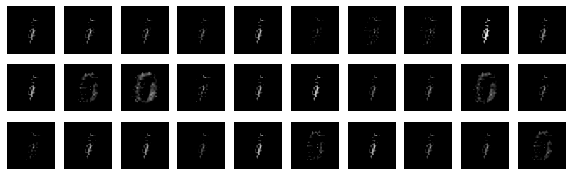

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 9 [0/60160]		D-Loss: 0.430623	G-Loss: 1.434604
Train | Epoch: 9 [12800/60160]		D-Loss: 0.636786	G-Loss: 9.139051
Train | Epoch: 9 [25600/60160]		D-Loss: 1.068544	G-Loss: 1.144606
Train | Epoch: 9 [38400/60160]		D-Loss: 0.222927	G-Loss: 2.912903
Train | Epoch: 9 [51200/60160]		D-Loss: 0.576980	G-Loss: 2.315627
====> Train | Epoch: 9 	 | 	Average D-loss: 0.5804 	 | 	Average G-loss: 2.3832
====> Test | Average D-loss: 0.3169 	 | 	Average G-loss: 3.0837


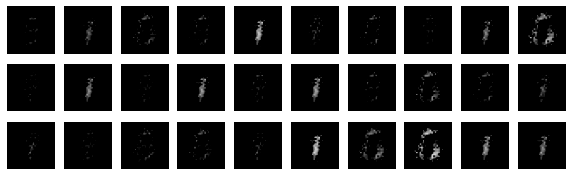

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 10 [0/60160]		D-Loss: 0.390047	G-Loss: 2.821356
Train | Epoch: 10 [12800/60160]		D-Loss: 0.303771	G-Loss: 2.324703
Train | Epoch: 10 [25600/60160]		D-Loss: 0.261381	G-Loss: 3.043000
Train | Epoch: 10 [38400/60160]		D-Loss: 0.298927	G-Loss: 3.604218
Train | Epoch: 10 [51200/60160]		D-Loss: 0.508842	G-Loss: 3.601454
====> Train | Epoch: 10 	 | 	Average D-loss: 0.2616 	 | 	Average G-loss: 3.6515
====> Test | Average D-loss: 0.4204 	 | 	Average G-loss: 3.5745


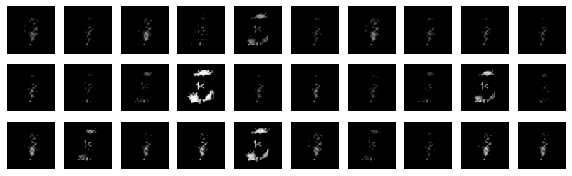

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 11 [0/60160]		D-Loss: 0.359692	G-Loss: 3.761034
Train | Epoch: 11 [12800/60160]		D-Loss: 0.544350	G-Loss: 2.628403
Train | Epoch: 11 [25600/60160]		D-Loss: 0.203649	G-Loss: 2.612399
Train | Epoch: 11 [38400/60160]		D-Loss: 0.245134	G-Loss: 6.171834
Train | Epoch: 11 [51200/60160]		D-Loss: 0.233232	G-Loss: 3.545014
====> Train | Epoch: 11 	 | 	Average D-loss: 0.3018 	 | 	Average G-loss: 4.1728
====> Test | Average D-loss: 0.1978 	 | 	Average G-loss: 4.3156


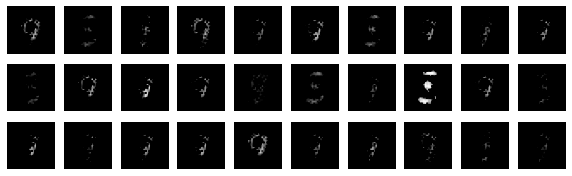

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 12 [0/60160]		D-Loss: 0.238930	G-Loss: 7.761128
Train | Epoch: 12 [12800/60160]		D-Loss: 0.333346	G-Loss: 5.534985
Train | Epoch: 12 [25600/60160]		D-Loss: 0.231739	G-Loss: 3.926227
Train | Epoch: 12 [38400/60160]		D-Loss: 0.243719	G-Loss: 3.619128
Train | Epoch: 12 [51200/60160]		D-Loss: 0.301812	G-Loss: 4.698525
====> Train | Epoch: 12 	 | 	Average D-loss: 0.2561 	 | 	Average G-loss: 4.0286
====> Test | Average D-loss: 0.2126 	 | 	Average G-loss: 3.8317


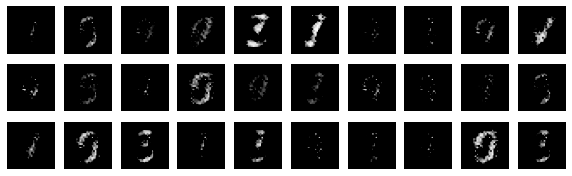

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 13 [0/60160]		D-Loss: 0.229430	G-Loss: 4.450501
Train | Epoch: 13 [12800/60160]		D-Loss: 0.195613	G-Loss: 3.563528
Train | Epoch: 13 [25600/60160]		D-Loss: 0.139474	G-Loss: 4.717405
Train | Epoch: 13 [38400/60160]		D-Loss: 0.304085	G-Loss: 3.364413
Train | Epoch: 13 [51200/60160]		D-Loss: 0.296347	G-Loss: 7.175857
====> Train | Epoch: 13 	 | 	Average D-loss: 0.1758 	 | 	Average G-loss: 5.1000
====> Test | Average D-loss: 0.2181 	 | 	Average G-loss: 4.4994


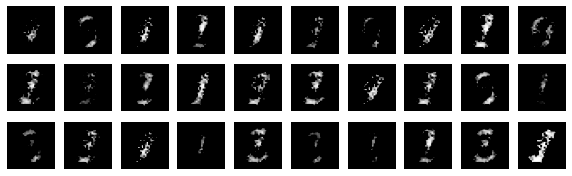

  0%|          | 0/235 [00:00<?, ?it/s]

Train | Epoch: 14 [0/60160]		D-Loss: 0.284123	G-Loss: 5.860944
Train | Epoch: 14 [12800/60160]		D-Loss: 0.197385	G-Loss: 3.344862
Train | Epoch: 14 [25600/60160]		D-Loss: 0.137103	G-Loss: 3.026428
Train | Epoch: 14 [38400/60160]		D-Loss: 0.099021	G-Loss: 3.695442
Train | Epoch: 14 [51200/60160]		D-Loss: 0.189919	G-Loss: 3.409070
====> Train | Epoch: 14 	 | 	Average D-loss: 0.1953 	 | 	Average G-loss: 4.5725
====> Test | Average D-loss: 0.2142 	 | 	Average G-loss: 2.8817


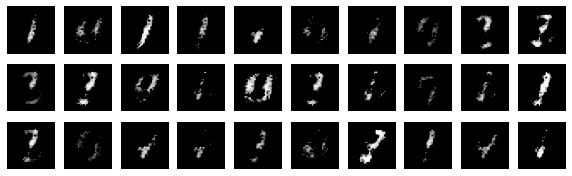

In [96]:
#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=14, G_update_times=1, D_update_times=1, verbose=True)
####################### End ########################

### 4.4.3) Final Visualization
It is an evaluating criteria for network architecture and parameter tuning (problems 16 to 19)

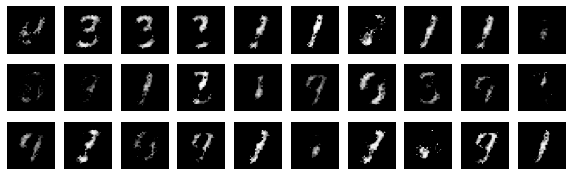

TypeError: ignored

In [118]:
mnist_visulization_helper_fn(mnist_trainer)
show_interpolations(mnist_trainer, 10, 10)